<a href="https://colab.research.google.com/github/Masciel-Sevilla/Segmentacion/blob/main/AnalisisExtraB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Paso 1: Descomprimir el dataset (esto solo se hace una vez)
import os
import zipfile

zip_path = '/content/Balanced.zip'
extract_path = '/content/'

# Solo descomprimir si no se ha hecho antes
if not os.path.exists(os.path.join(extract_path, 'Balanced')):
    print(f"Descomprimiendo {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("¡Descompresión completada!")
else:
    print("La carpeta 'Balanced' ya existe. Omitiendo descompresión.")

La carpeta 'Balanced' ya existe. Omitiendo descompresión.


🔬 ANÁLISIS EN PROFUNDIDAD DE IMÁGENES SELECCIONADAS
✅ Modelo 'efficient_weed_model_B0_best.keras' cargado exitosamente.

▶️  Iniciando análisis para 6 imagen(es) seleccionada(s)...



/tmp/ipython-input-3170348352.py:217: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/tmp/ipython-input-3170348352.py:217: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/tmp/ipython-input-3170348352.py:217: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/tmp/ipython-input-3170348352.py:217: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/tmp/ipython-input-3170348352.py:217: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


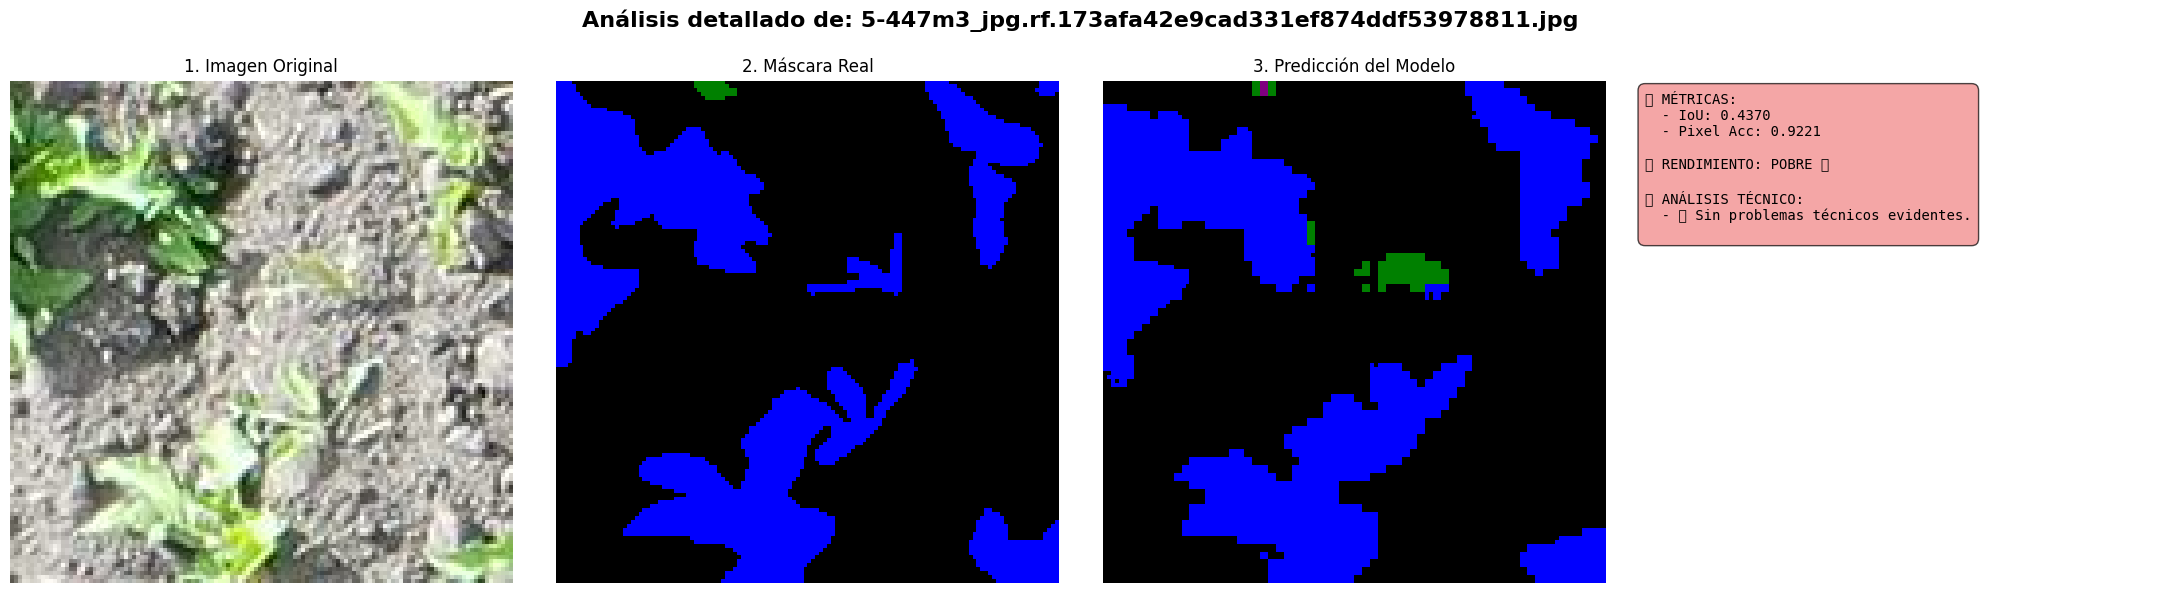

/tmp/ipython-input-3170348352.py:217: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


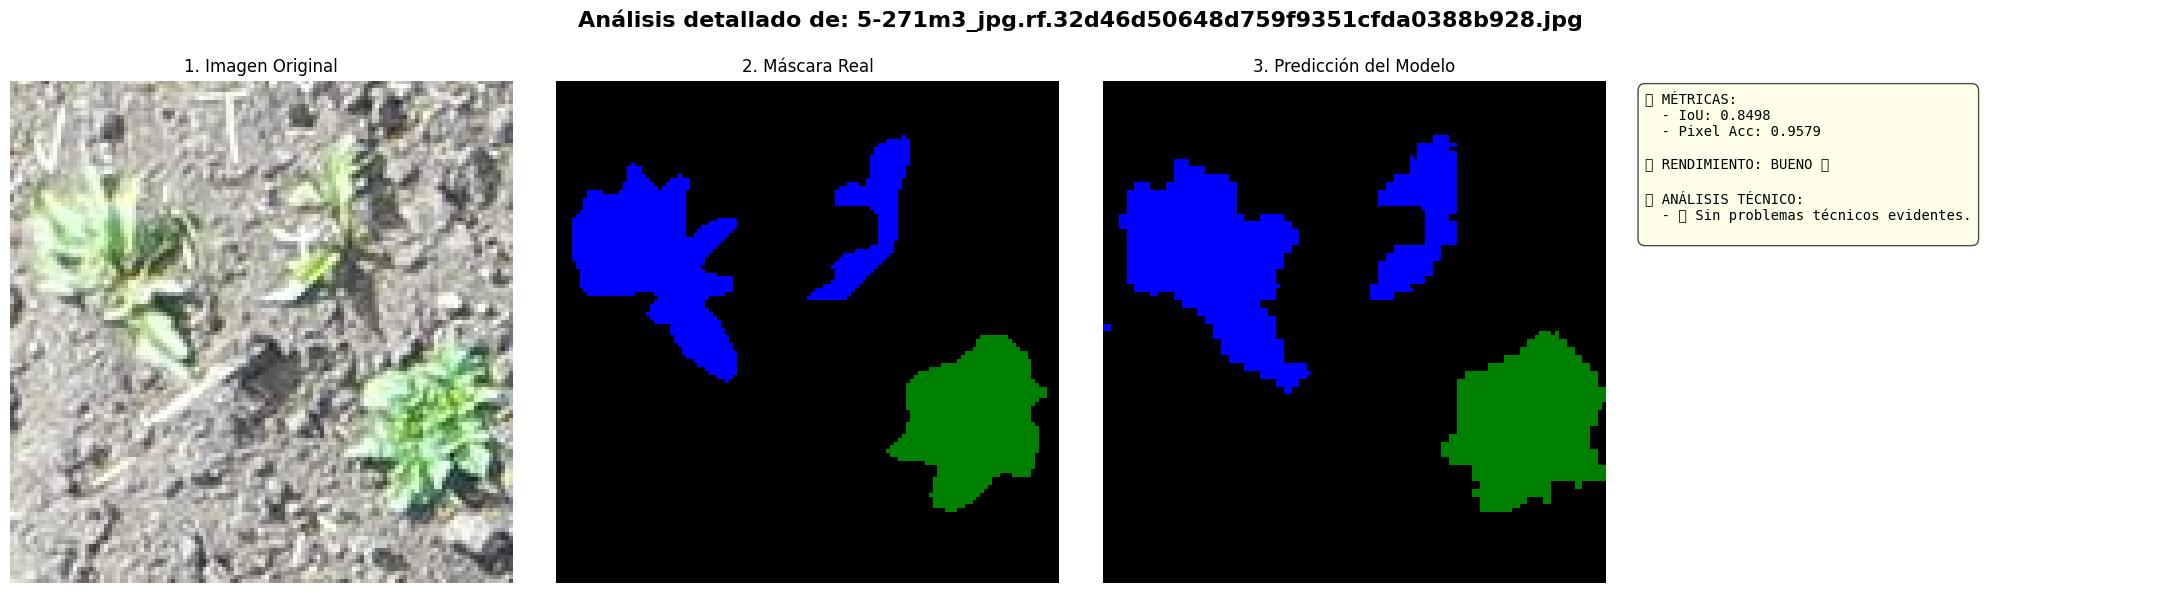

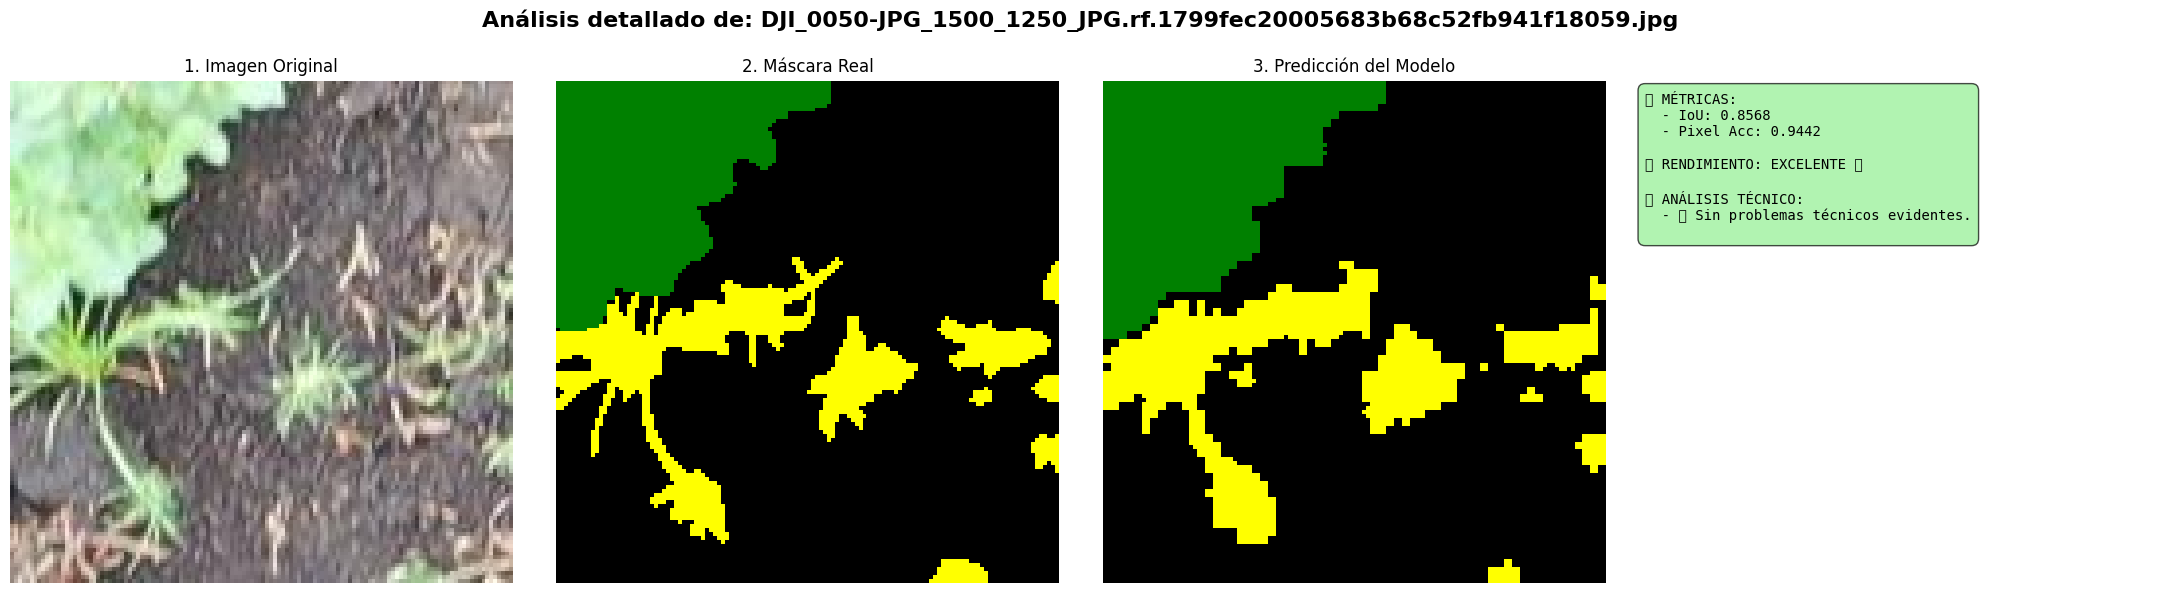

/tmp/ipython-input-3170348352.py:217: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


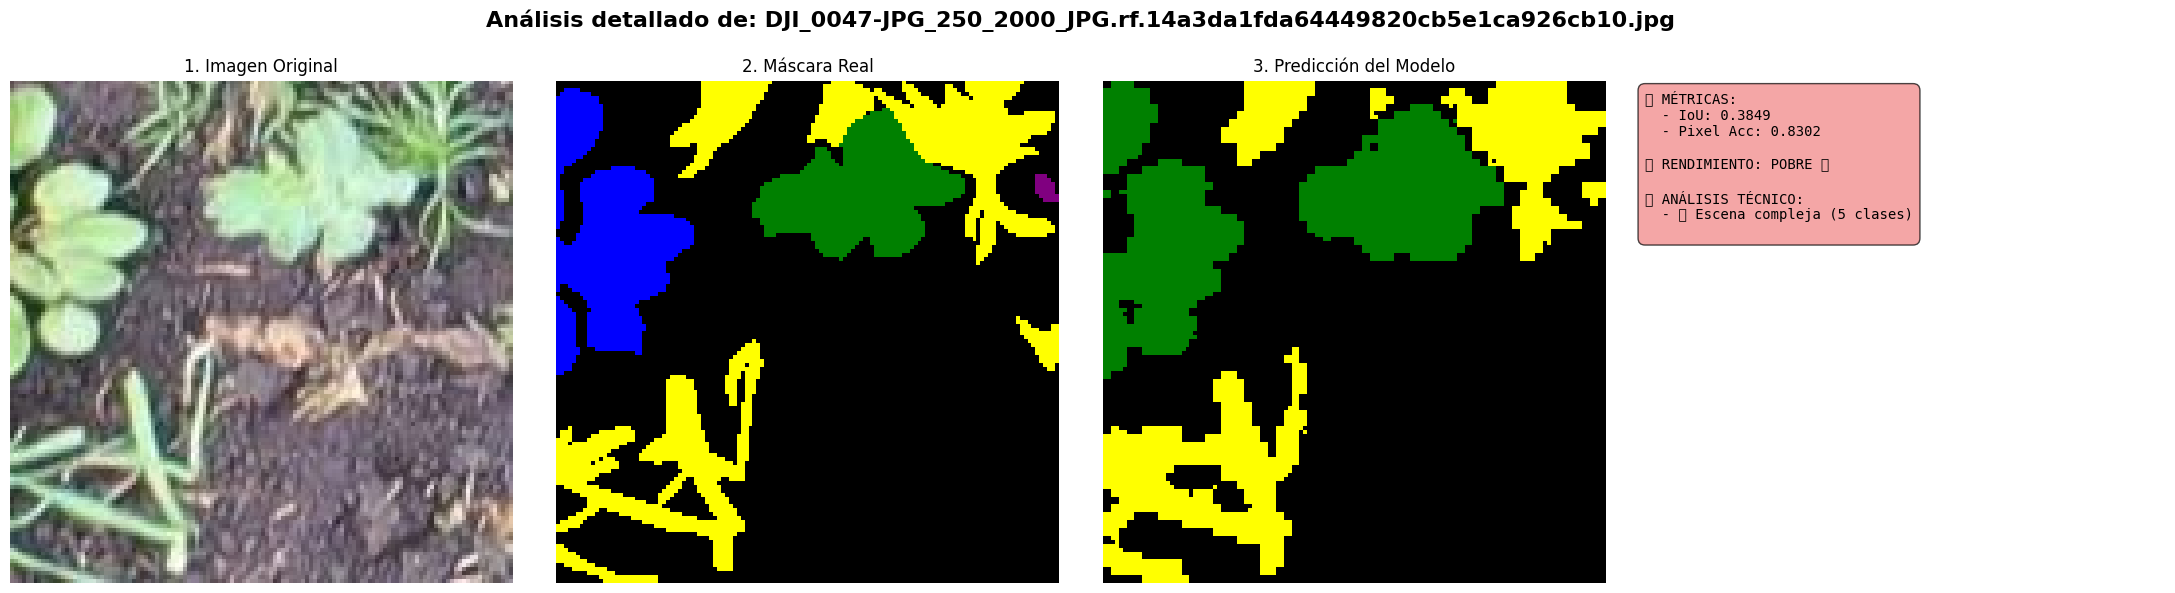

/tmp/ipython-input-3170348352.py:217: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


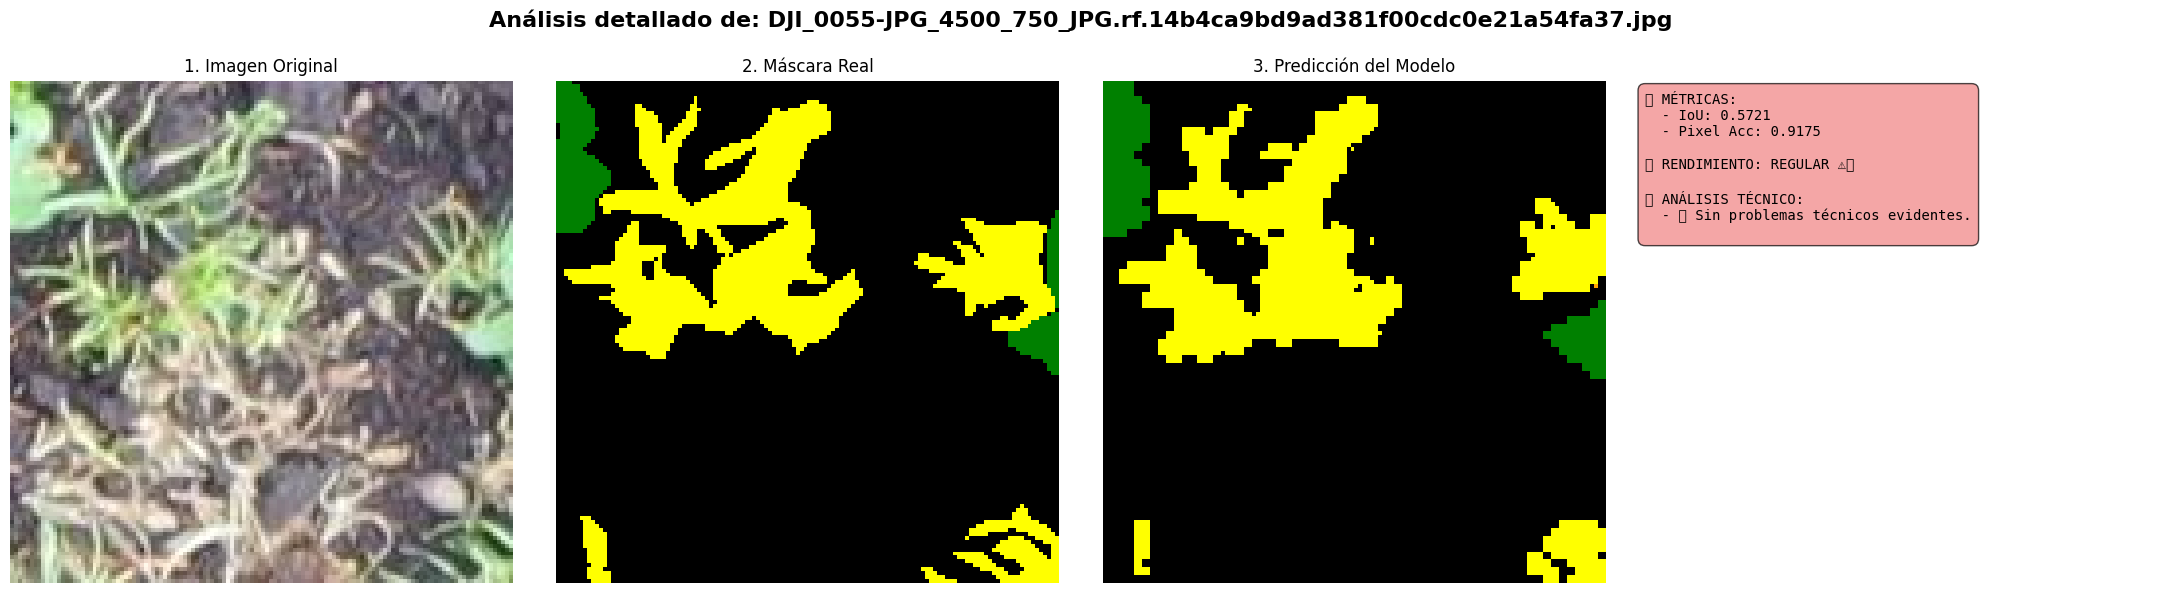

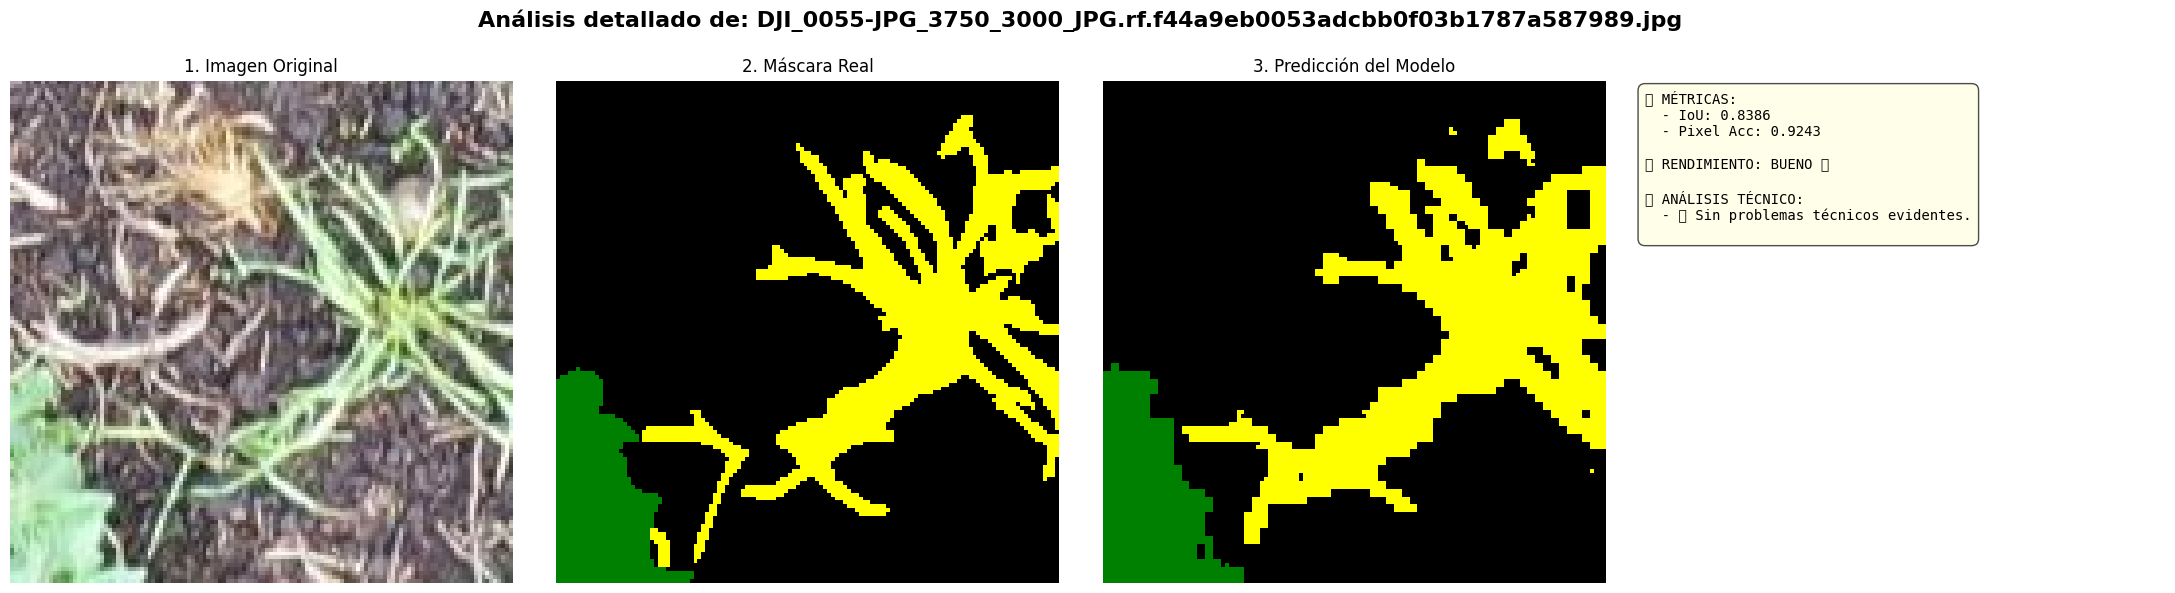

🏁 Análisis finalizado.


In [11]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from glob import glob # Aunque no se usa directamente en este enfoque, es bueno mantenerlo si planeas explorar.
import cv2

# --- 1. CONFIGURACIÓN PRINCIPAL ---
MODEL_PATH = 'efficient_weed_model_B0_best.keras'
BASE_PATH = './Balanced'
IMG_HEIGHT = 128
IMG_WIDTH = 128
NUM_CLASSES = 6 # Se incluye el fondo (Background)

# =================================================================
#  ✅ ¡AQUÍ! Edita esta lista con los nombres de archivo exactos
#       de las imágenes complejas que quieres analizar.
# =================================================================
IMAGES_TO_ANALYZE = [
    '5-447m3_jpg.rf.173afa42e9cad331ef874ddf53978811.jpg', # Ejemplo 1
    '5-271m3_jpg.rf.32d46d50648d759f9351cfda0388b928.jpg', # Ejemplo 2
    'DJI_0050-JPG_1500_1250_JPG.rf.1799fec20005683b68c52fb941f18059.jpg',
    'DJI_0047-JPG_250_2000_JPG.rf.14a3da1fda64449820cb5e1ca926cb10.jpg',
    'DJI_0055-JPG_4500_750_JPG.rf.14b4ca9bd9ad381f00cdc0e21a54fa37.jpg',
    'DJI_0055-JPG_3750_3000_JPG.rf.f44a9eb0053adcbb0f03b1787a587989.jpg',
    # Puedes añadir más nombres de archivo aquí
]
# =================================================================

# Nombres y colores ACTUALIZADOS según tu imagen
CLASS_NAMES = ['Background', 'Cow-tongue', 'Dandelion', 'Kikuyo', 'Other', 'Potato']

# Los valores RGB (0-255) se dividen entre 255 para normalizarlos a (0-1)
CLASS_COLORS = [
    [0/255, 0/255, 0/255],          # 0: Background - Negro (añadido)
    [0/255, 0/255, 255/255],        # 1: Cow-tongue - Azul
    [255/255, 165/255, 0/255],      # 2: Dandelion  - Naranja
    [255/255, 255/255, 0/255],      # 3: Kikuyo     - Amarillo
    [128/255, 0/255, 128/255],      # 4: Other      - Púrpura
    [0/255, 128/255, 0/255]         # 5: Potato     - Verde
]

# --- 2. DEFINICIONES DE CAPAS PERSONALIZADAS DEL MODELO ---
# (Deben ser exactas a las usadas durante el entrenamiento)

class ASPPModule(layers.Layer):
    def __init__(self, filters=192, **kwargs):
        super(ASPPModule, self).__init__(**kwargs)
        self.filters = filters
        self.conv_1x1 = layers.Conv2D(filters, 1, padding='same', use_bias=False)
        self.bn_1x1 = layers.BatchNormalization()
        self.relu_1x1 = layers.ReLU()
        self.conv_3x3_6 = layers.Conv2D(filters, 3, padding='same', dilation_rate=6, use_bias=False)
        self.bn_3x3_6 = layers.BatchNormalization()
        self.relu_3x3_6 = layers.ReLU()
        self.conv_3x3_12 = layers.Conv2D(filters, 3, padding='same', dilation_rate=12, use_bias=False)
        self.bn_3x3_12 = layers.BatchNormalization()
        self.relu_3x3_12 = layers.ReLU()
        self.conv_3x3_18 = layers.Conv2D(filters, 3, padding='same', dilation_rate=18, use_bias=False)
        self.bn_3x3_18 = layers.BatchNormalization()
        self.relu_3x3_18 = layers.ReLU()
        self.global_avg_pool = layers.GlobalAveragePooling2D(keepdims=True)
        self.conv_1x1_gap = layers.Conv2D(filters, 1, padding='same', use_bias=False)
        self.bn_1x1_gap = layers.BatchNormalization()
        self.relu_1x1_gap = layers.ReLU()
        self.conv_final = layers.Conv2D(filters, 1, padding='same', use_bias=False)
        self.bn_final = layers.BatchNormalization()
        self.relu_final = layers.ReLU()
        self.dropout = layers.Dropout(0.2)
    def call(self, inputs, training=None):
        input_shape = tf.shape(inputs)
        conv_1x1 = self.relu_1x1(self.bn_1x1(self.conv_1x1(inputs), training=training))
        conv_3x3_6 = self.relu_3x3_6(self.bn_3x3_6(self.conv_3x3_6(inputs), training=training))
        conv_3x3_12 = self.relu_3x3_12(self.bn_3x3_12(self.conv_3x3_12(inputs), training=training))
        conv_3x3_18 = self.relu_3x3_18(self.bn_3x3_18(self.conv_3x3_18(inputs), training=training))
        gap = self.global_avg_pool(inputs)
        gap = self.relu_1x1_gap(self.bn_1x1_gap(self.conv_1x1_gap(gap), training=training))
        gap = tf.image.resize(gap, [input_shape[1], input_shape[2]], method='bilinear')
        concat = layers.Concatenate()([conv_1x1, conv_3x3_6, conv_3x3_12, conv_3x3_18, gap])
        output = self.relu_final(self.bn_final(self.conv_final(concat), training=training))
        output = self.dropout(output, training=training)
        return output

class DeformableAttention(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(DeformableAttention, self).__init__(**kwargs)
        self.filters = filters
    def build(self, input_shape):
        self.attention_conv = layers.Conv2D(self.filters, 1, padding='same', activation='sigmoid', name='attention_weights_conv', use_bias=False)
        self.bn_attention = layers.BatchNormalization()
        self.feature_conv = layers.SeparableConv2D(self.filters, 3, padding='same', name='feature_processing_conv', use_bias=False)
        self.bn_feature = layers.BatchNormalization()
        self.relu_feature = layers.ReLU()
        super(DeformableAttention, self).build(input_shape)
    def call(self, inputs, training=None):
        attention_weights = self.bn_attention(self.attention_conv(inputs), training=training)
        features = self.relu_feature(self.bn_feature(self.feature_conv(inputs), training=training))
        attended_features = features * attention_weights
        return attended_features

# Funciones dummy para que Keras pueda cargar el modelo aunque no las use en la predicción
def dice_coefficient(y_true, y_pred, smooth=1e-6): return 0.0
def iou_metric(y_true, y_pred): return 0.0
def combined_loss(y_true, y_pred): return 0.0

# --- 3. FUNCIONES DE CARGA Y ANÁLISIS ---

def load_and_preprocess_image(image_path, mask_path):
    """Carga y preprocesa una imagen y su máscara."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest')

    return image, mask

def analyze_prediction_issues(image_np, true_mask_np, pred_logits):
    """Analiza técnicamente por qué una predicción podría ser buena o mala."""
    issues = []
    pred_mask_np = np.argmax(pred_logits, axis=-1)

    # 1. Complejidad de la escena
    unique_classes_true = len(np.unique(true_mask_np))
    if unique_classes_true > 4:
        issues.append(f"🔬 Escena compleja ({unique_classes_true} clases)")

    # 2. Calidad de imagen (contraste y nitidez)
    # Asegúrate de que image_np esté en el rango 0-255 antes de convertir a uint8
    if image_np.max() <= 1.0: # Si la imagen está normalizada a 0-1
        gray_img = cv2.cvtColor((image_np * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    else: # Si ya está en 0-255
        gray_img = cv2.cvtColor(image_np.astype(np.uint8), cv2.COLOR_RGB2GRAY)

    contrast = np.std(gray_img)
    laplacian_var = cv2.Laplacian(gray_img, cv2.CV_64F).var()
    if contrast < 35: issues.append("📉 Bajo contraste en imagen")
    if laplacian_var < 80: issues.append("🌫️ Imagen algo borrosa")

    # 3. Confianza de la predicción
    prediction_confidence = np.max(pred_logits, axis=-1)
    low_confidence_pixels = np.sum(prediction_confidence < 0.75) / (IMG_HEIGHT * IMG_WIDTH)
    if low_confidence_pixels > 0.2:
        issues.append(f"🤔 Modelo con baja confianza ({low_confidence_pixels*100:.1f}% de píxeles)")

    # 4. Análisis de fragmentación
    num_true_objects = 0
    for class_id in range(1, NUM_CLASSES): # Omitir background
        class_mask = (true_mask_np == class_id).astype(np.uint8)
        if np.sum(class_mask) > 0:
            _, labels = cv2.connectedComponents(class_mask)
            num_objects = len(np.unique(labels)) - 1
            num_true_objects += num_objects
    if num_true_objects > 10:
        issues.append(f"🧩 Alta fragmentación ({num_true_objects} objetos)")

    if not issues:
        issues.append("✅ Sin problemas técnicos evidentes.")

    return issues

# --- 4. FUNCIÓN DE VISUALIZACIÓN ---

def plot_detailed_analysis(image, true_mask, pred_mask, iou, pixel_acc, issues, filename):
    """Genera una gráfica detallada de 4 columnas para una sola imagen."""
    custom_cmap = ListedColormap(CLASS_COLORS)

    fig, axes = plt.subplots(1, 4, figsize=(22, 6))

    plt.suptitle(f"Análisis detallado de: {os.path.basename(filename)}", fontsize=16, fontweight='bold')

    # Columna 1: Imagen Original
    axes[0].imshow(image.astype('uint8'))
    axes[0].set_title("1. Imagen Original", fontsize=12)
    axes[0].axis('off')

    # Columna 2: Máscara Real (Ground Truth)
    axes[1].imshow(true_mask, cmap=custom_cmap, vmin=0, vmax=NUM_CLASSES-1)
    axes[1].set_title("2. Máscara Real", fontsize=12)
    axes[1].axis('off')

    # Columna 3: Predicción del Modelo
    axes[2].imshow(pred_mask, cmap=custom_cmap, vmin=0, vmax=NUM_CLASSES-1)
    axes[2].set_title("3. Predicción del Modelo", fontsize=12)
    axes[2].axis('off')

    # Columna 4: Análisis y Métricas
    axes[3].axis('off')

    # Clasificación del rendimiento
    if iou > 0.85: performance = "EXCELENTE ✅"
    elif iou > 0.70: performance = "BUENO 👍"
    elif iou > 0.50: performance = "REGULAR ⚠️"
    else: performance = "POBRE ❌"

    analysis_text = f"📊 MÉTRICAS:\n"
    analysis_text += f"  - IoU: {iou:.4f}\n"
    analysis_text += f"  - Pixel Acc: {pixel_acc:.4f}\n\n"
    analysis_text += f"⭐ RENDIMIENTO: {performance}\n\n"
    analysis_text += f"🔍 ANÁLISIS TÉCNICO:\n"
    for issue in issues[:4]: # Mostrar hasta 4 problemas
        analysis_text += f"  - {issue}\n"

    # Color de fondo según el rendimiento
    if iou > 0.85: bg_color = "lightgreen"
    elif iou > 0.70: bg_color = "lightyellow"
    else: bg_color = "lightcoral"

    axes[3].text(0.02, 0.98, analysis_text, transform=axes[3].transAxes,
                   fontsize=10, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor=bg_color, alpha=0.7))

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- 5. FUNCIÓN PRINCIPAL DE EJECUCIÓN ---

def main_analysis():
    print("="*80)
    print("🔬 ANÁLISIS EN PROFUNDIDAD DE IMÁGENES SELECCIONADAS")
    print("="*80)

    # Cargar el modelo
    custom_objects = {
        'ASPPModule': ASPPModule, 'DeformableAttention': DeformableAttention,
        'combined_loss': combined_loss, 'dice_coefficient': dice_coefficient, 'iou_metric': iou_metric
    }
    try:
        model = tf.keras.models.load_model(MODEL_PATH, custom_objects=custom_objects)
        print(f"✅ Modelo '{MODEL_PATH}' cargado exitosamente.")
    except Exception as e:
        print(f"❌ Error fatal: No se pudo cargar el modelo. Revisa la ruta y las capas personalizadas. Error: {e}")
        return

    # Construir las rutas a partir de la lista IMAGES_TO_ANALYZE
    test_images_dir = os.path.join(BASE_PATH, 'test/images')
    test_masks_dir = os.path.join(BASE_PATH, 'test/masks')

    image_paths_to_process = []
    for filename in IMAGES_TO_ANALYZE:
        img_path = os.path.join(test_images_dir, filename)

        # --- ✅ CORRECCIÓN AQUÍ: Construcción de la ruta de la máscara ---
        base_name = os.path.splitext(filename)[0] # Obtiene '5-446m3_jpg.rf.7be...'
        mask_filename = base_name + '_mask.png'   # Añade '_mask.png'
        mask_path = os.path.join(test_masks_dir, mask_filename) # Ruta completa a la máscara

        if os.path.exists(img_path) and os.path.exists(mask_path):
            image_paths_to_process.append((img_path, mask_path))
        else:
            print(f"⚠️  Advertencia: No se encontró la imagen '{img_path}' o su máscara '{mask_path}'. Se omitirá.")

    if not image_paths_to_process:
        print("❌ No se procesará ninguna imagen. Verifica los nombres en la lista 'IMAGES_TO_ANALYZE'.")
        return

    print(f"\n▶️  Iniciando análisis para {len(image_paths_to_process)} imagen(es) seleccionada(s)...\n")

    # Bucle principal de análisis
    for img_path, mask_path in image_paths_to_process:
        # Cargar y preprocesar
        image_tensor, mask_tensor = load_and_preprocess_image(img_path, mask_path)

        # Preparar imagen para el modelo (normalización de EfficientNetV2)
        image_for_model = tf.keras.applications.efficientnet_v2.preprocess_input(tf.cast(image_tensor, tf.float32))

        # Realizar predicción
        pred_logits = model.predict(tf.expand_dims(image_for_model, 0), verbose=0)[0]
        pred_mask = tf.argmax(pred_logits, axis=-1)

        # Convertir a NumPy para análisis y visualización
        image_np = image_tensor.numpy()
        true_mask_np = mask_tensor.numpy().squeeze()
        pred_mask_np = pred_mask.numpy()

        # Calcular métricas
        iou = tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES)
        iou.update_state(true_mask_np, pred_mask_np)
        iou_score = iou.result().numpy()

        pixel_accuracy = np.sum(true_mask_np == pred_mask_np) / (IMG_HEIGHT * IMG_WIDTH)

        # Obtener análisis técnico
        issues = analyze_prediction_issues(image_np, true_mask_np, pred_logits)

        # Generar la gráfica
        plot_detailed_analysis(image_np, true_mask_np, pred_mask_np, iou_score, pixel_accuracy, issues, img_path)

    print("🏁 Análisis finalizado.")

# --- 6. EJECUCIÓN DEL SCRIPT ---
if __name__ == "__main__":
    main_analysis()